# Chapter 5

In [355]:
import os
import warnings

import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from aesara import shared
# CausalGraphicalModels needs the following import, and alias
import collections.abc
collections.Iterable = collections.abc.Iterable
from causalgraphicalmodels import CausalGraphicalModel
from scipy import stats
from scipy.interpolate import griddata
import xarray as xr

warnings.simplefilter(action="ignore", category=FutureWarning)

In [356]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
np.random.seed(0)

In [357]:
# Load data
data = pd.read_csv(os.path.join("Data", "WaffleDivorce.csv"), delimiter=";")

In [358]:
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


We define a quick helper function that takes a `pandas` series object and returns the standard score associated with each element in the series.  This is what the  `scale()` function in `R` does.

In [359]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

We add a standardized Divorce rate, `Divorce_std`, a standardized marriage rate, `Marriage_std`, a standardized median age at marriage, `MAM_std`, and a Waffle House per Million, `WH_per_MM`, to the data frame.  ( The `WH_per_MM` is added so that we can reproduce the Figure 5.1.)

#### Code 5.1

In [360]:
data['Divorce_std'] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data['MedianAgeMarriage_std'] = standardize(data["MedianAgeMarriage"])
data['WH_per_MM'] = data["WaffleHouses"]/data["Population"]

For fun, lets recreate the Figure 5.1.

We will define a linear model with loose priors.

In [361]:
with pm.Model() as m_5_0:
    a = pm.Normal("a", 10, 2) # prior for the intercept.
    bA = pm.Lognormal("bA", 0, 1) # prior for the slope assumes a positive correlation.
    sigma = pm.Uniform("sigma", 0, 20) # prior for the standard deviation is very loose.
    mu = pm.Deterministic("mu", a + bA * data["WH_per_MM"].values)
    divorce_rate = pm.Normal(
        "divorce_rate", mu=mu, sigma=sigma, observed=data["Divorce"].values
    )
    m_5_0_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


We will plot the predicted mean, and we will plot the HDI for the predicted mean.

In [362]:
mu_pred = m_5_0_trace.posterior["mu"]
thined_data = m_5_0_trace.sel(draw=slice(None, None, 5))
with m_5_0:
    divorce_pred = pm.sample_posterior_predictive(thined_data)

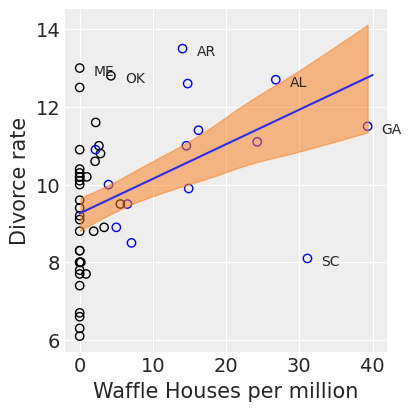

In [363]:
# Fig 5.1
fig, ax = plt.subplots(figsize=(4,4))

# assign colours to confederate states
colors = {"1": "blue", "0": "black"}

ax.scatter(
    data["WH_per_MM"],
    data["Divorce"],
    lw=1,
    color=(0, 0, 0, 0),
    edgecolor=data["South"].apply(lambda x: colors[str(x)]),
)
ax.plot(np.linspace(0,40), m_5_0_trace.posterior["a"].mean().item(0) +
                            m_5_0_trace.posterior["bA"].mean().item(0) * np.linspace(0,40))
az.plot_hdi(data["WH_per_MM"], mu_pred, hdi_prob=0.89)

ax.set_xlabel("Waffle Houses per million")
ax.set_ylabel("Divorce rate")

# take only the states with Divorce rate over 12.6 or number of Waffle houses per million inhabitants over 30
selection = data[(data["Divorce"] > 12.6) | (data["WH_per_MM"] > 30)]

# label those points
for state, div, ratio in zip(
    selection["Loc"],
    selection["WaffleHouses"] / selection["Population"],
    selection["Divorce"],
):
    ax.annotate(f"{state}", xy=(div, ratio), textcoords="offset points", xytext=(10, -5))

We are going to do the same for the marriage rate vs divorce rate, and median age at marriage vs the divorce rate.  First here is a plot of the raw data.

Text(0.5, 0, 'Median age marriage')

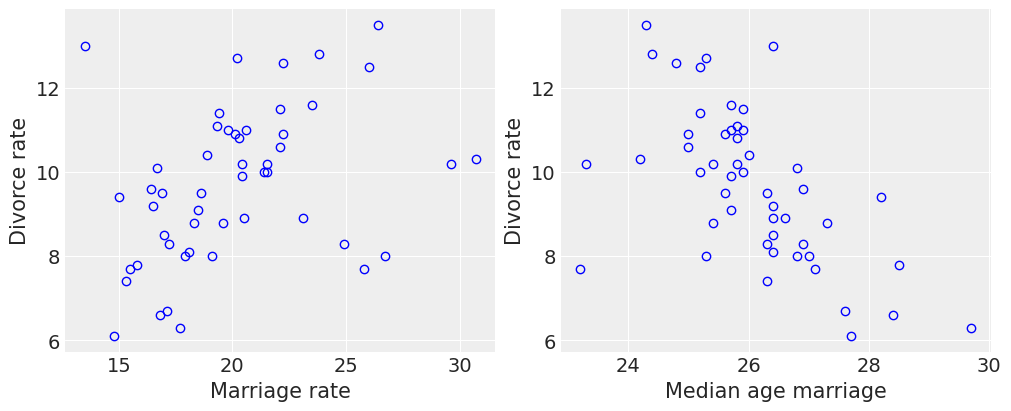

In [364]:
# Fig 5.2, missing mean and CI
fid, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(data["Marriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[0].set_ylabel("Divorce rate")
ax[0].set_xlabel("Marriage rate")

ax[1].scatter(data["MedianAgeMarriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[1].set_ylabel("Divorce rate")
ax[1].set_xlabel("Median age marriage")

Looking at the standard deviation of the median age at marriage to get a sense of what our prior should be.

#### Code 5.2

In [365]:
data["MedianAgeMarriage"].std()

1.2436303013880823

And we define our linear model using the priors in the text.

#### Code 5.3

In [366]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bA * data["MedianAgeMarriage_std"].values)

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    m_5_1_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


#### Code 5.4

To simulate from the priors we can use the `pymc.sample_prior_predictive()` as we have before.

In [367]:
with m_5_1:
    # sample to enable prior predictive check
    prior = pm.sample_prior_predictive(samples=50).prior

Plotting over 2 standard deviations in the predictor as is done in the text.

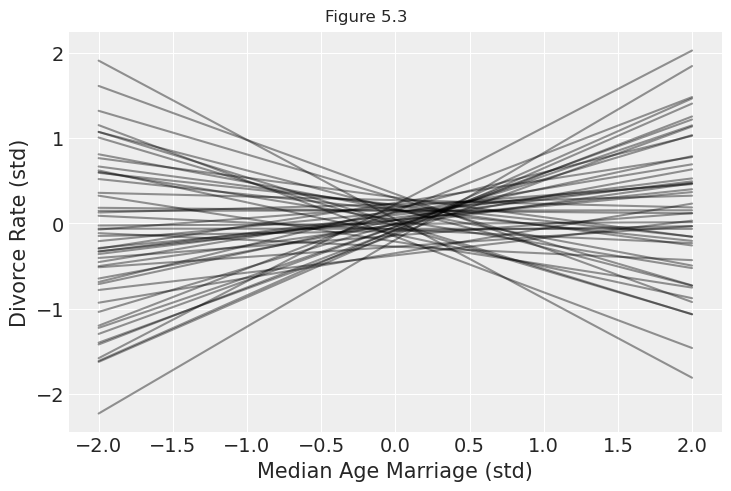

In [368]:
fig, ax = plt.subplots()

x = np.linspace(-2,2,50)

intercepts = prior['a'][0].to_numpy()
slopes = prior['bA'][0].to_numpy()

for a, ba in zip(intercepts, slopes):
    y = a + ba * x
    ax.plot(x, y, c="black", alpha=0.4)

ax.set_xlabel("Median Age Marriage (std)")
ax.set_ylabel("Divorce Rate (std)")
fig.suptitle("Figure 5.3");

#### Code 5.5

Posterior predictions:

In [369]:
# This is equivalent of link function.  From the Rethinking_2 pg.107
# What link will do is take your quap approximation, sample from the posterior
# distribution, and then compute µ for each case in the data and sample from the posterior
# distribution.

# create a sequence of uniformly spaced 'standard ages' for our data from -3 to 3.2
age_std_seq = np.linspace(-3, 3.2, 30)

# Given that we have a lot of samples we can use less of them for plotting.
# the following will sample every 10th value.
# m_5_1_trace = m_5_1_trace.sel(draw=slice(None, None, 10).

# or we can use all!

m_5_1_data = az.extract_dataset(m_5_1_trace.posterior)

# create a matrix to store our predicted mu based on our samples
mu_pred = np.zeros((len(age_std_seq), len(m_5_1_data.sample)))

for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = m_5_1_data["a"] + m_5_1_data["bA"] * age_std

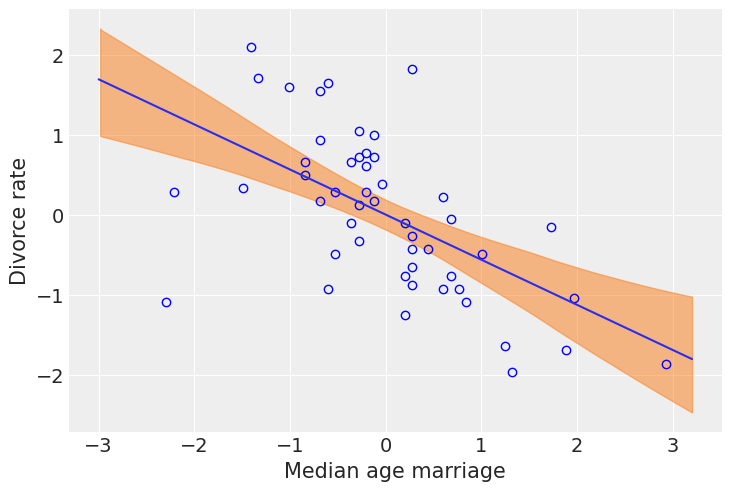

In [370]:
# Now I need to take average of mu and plot
# I should get 30 averages, one for each x
mu_mean = mu_pred.mean(axis=1)

# This is equivalent of Percent Interval
ax = az.plot_hdi(age_std_seq, mu_pred.T)
plt.plot(age_std_seq, mu_mean)

# add in our data, standardized this time.
ax.scatter(data["MedianAgeMarriage_std"], data["Divorce_std"], lw=1, color=(0, 0, 0, 0), edgecolor="b")

ax.set_xlabel("Median age marriage")
ax.set_ylabel("Divorce rate");

Doing the same thing now for the Marriage rate vs divorce rate

#### 5.6

The model is defined as we did above.<a id="m_5_2"></a>

In [371]:
with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM * data["Marriage_std"].values)
    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


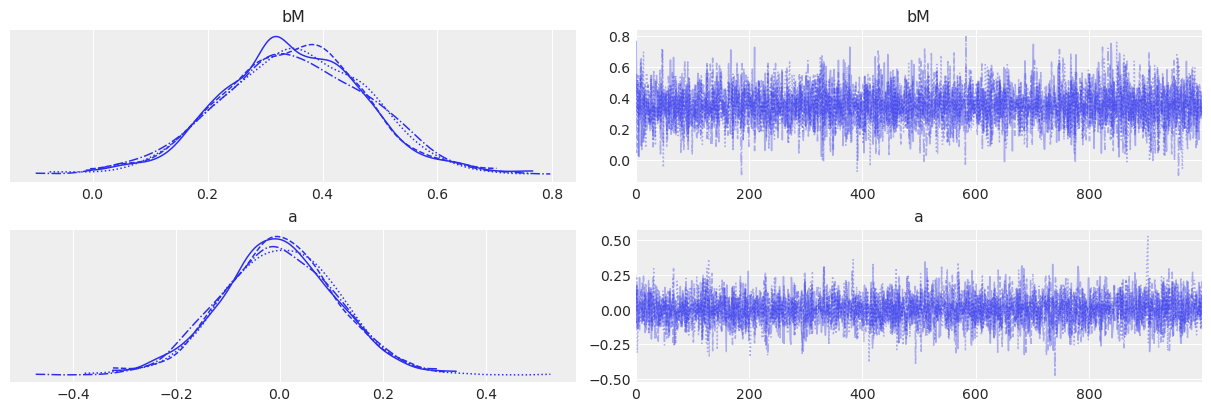

In [372]:
az.plot_trace(m_5_2_trace, var_names=["bM", "a"]);

And we could plot it as we did [above](#figure5.2):

In [373]:
# create a sequence of uniformly spaced 'standard ages' for our data from -3 to 3.2
marriage_rate_std_seq = np.linspace(-2, 3, 30)

m_5_2_data = az.extract_dataset(m_5_2_trace.posterior)

# create a matrix to store our predicted mu based on our samples
mu_pred_5_2 = np.zeros((len(marriage_rate_std_seq), len(m_5_2_data.sample)))

for i, marriage_rate_std in enumerate(marriage_rate_std_seq):
    mu_pred_5_2[i] = m_5_2_data["a"] + m_5_2_data["bM"] * marriage_rate_std

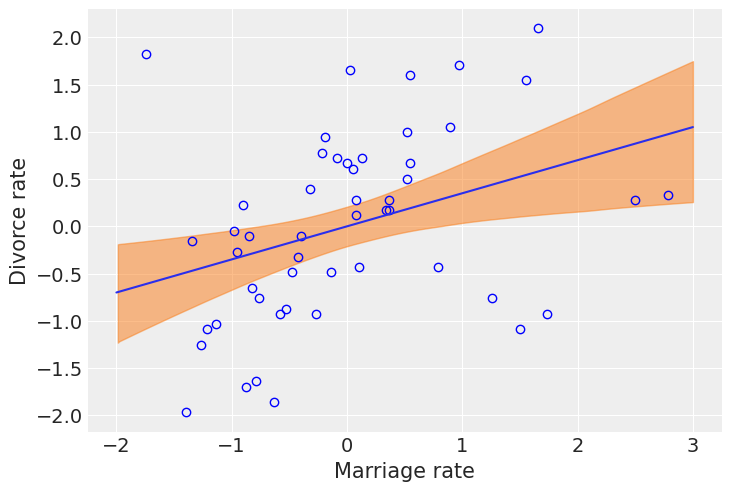

In [374]:
# Now I need to take average of mu and plot
# I should get 30 averages, one for each x
mu_mean = mu_pred_5_2.mean(axis=1)

# This is equivalent of Percent Interval
ax = az.plot_hdi(marriage_rate_std_seq, mu_pred_5_2.T)
plt.plot(marriage_rate_std_seq, mu_mean)

# add in our data, standardized this time.
ax.scatter(data["Marriage_std"], data["Divorce_std"], lw=1, color=(0, 0, 0, 0), edgecolor="b")

ax.set_xlabel("Marriage rate")
ax.set_ylabel("Divorce rate");

#### 5.7
Credit to [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/05_the_many_variables_and_the_spurious_waffles#Code-5.7)


Author suggests that merely comparing parameter means between bivariate regressions is no way to decide which predictor is better. They may be independent, or related or could eliminate each other. 

How do we understand all this ?

He explains that here we may want to think **causally**. 

Few interesting assumptions (or rather deductions) -

* a) Age has a direct impact on Divorce rate as people may grow incompatible with the parter 

* b) Marriage Rate has a direct impact on Divorce rate for obvious reason (more marriages => more divorce)

* c) Finally, Age has an impact on Marriage Rate because there are more young people

Another way to represent above is :

A -> D

M -> D

A -> M

and yet another way is to use **DAG** (Directed Acyclic Graphs)


/home/guy/Applications/anaconda3/envs/pymc_env/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/guy/Applications/anaconda3/envs/pymc_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


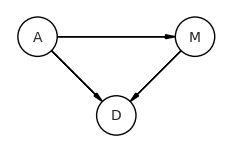

In [375]:
dag5_1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

Above DAG clearly shows that A impacts D directly and indirectly (i.e. via M)

The author used "total influence". What is meant by *total* is that we need to account for every path from **A** to **D**.

**MEDIATION** - Let's say that **A** did not directly influence **D**; rather it did it via **M**. This type of relationship is called *Mediation*


Author raises many interesting questions here. He asks if there is indeed a direct effect of marriage rate or rather is age at marriage just driving both, creating a **spurious** correlation between marriage rate and divorce rate


#### 5.8

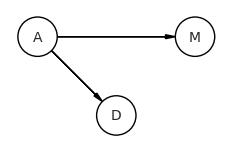

In [376]:
# Note - There is no explicit code section for drawing the second DAG
# but the figure appears in the book and hence drawing it as well
dag5_2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_2.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

We can get the joint probability distribution implied by our causal graphical model using

In [377]:
print(dag5_2.get_distribution())

P(A)P(D|A)P(M|A)


To see the Conditional Independencies, we can use one of the following two snippets. The explanation is that **M** and **D** are not independent, unless we condition on **A** when they become conditionally independent.

In [378]:
dag5_2.get_all_independence_relationships()

[('M', 'D', {'A'})]

In [379]:
DMA_dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('M', 'D', {'A'})


#### 5.9

Checking the independencies in the first DAG

In [380]:
DMA_dag1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
all_independencies = DMA_dag1.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

Executing above cell should not display anything as in the DAG1 (where all nodes are connected to each other) there are no conditional independencies.

In [381]:
from pgmpy.models import BayesianNetwork
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.inference import CausalInference

import warnings
warnings.filterwarnings('ignore')

/home/guy/Applications/anaconda3/envs/pymc_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [382]:
dag_5_1 = BayesianModel([("A", "D"), ("A", "M"), ("M", "D")])

<Axes: >

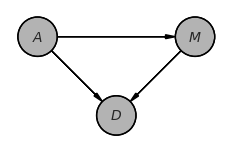

In [383]:
dag_5_1.to_daft(node_pos={"A": (0,1), "M": (2,1), "D": (1,0)}).render()

<Axes: >

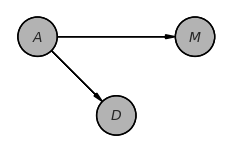

In [605]:
dag_5_2 = BayesianModel([("A", "M"), ("A", "D")])
dag_5_2.to_daft(node_pos={"A": (0,1), "M": (2,1), "D": (1,0)}).render()

In [606]:
dag_5_2.local_independencies('D')

(D ⟂ M | A)

#### 5.10

In [386]:
with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic(
        "mu", a + bM * data["Marriage_std"].values + bA * data["MedianAgeMarriage_std"].values
    )
    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_3_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


The question posed in the text is what is the effect of adding in the mean age at marriage to our model of how marriage rate affects divorce rate.  For reference, the summary for our marriage rate vs divorce rate [m_5_2](#m_5_2).

In [387]:
az.summary(m_5_2_trace, var_names=["a", "bM", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.111,-0.209,0.204,0.001,0.002,6108.0,2858.0,1.0
bM,0.350,0.127,0.098,0.580,0.002,0.001,5880.0,3360.0,1.0
sigma,0.946,0.097,0.769,1.124,0.001,0.001,5139.0,2920.0,1.0


When we now look at the summary, notice how in the new model `bM` is now close to zero.

In [388]:
az.summary(m_5_3_trace, var_names=["a", "bM", "bA", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.001,0.102,-0.203,0.178,0.002,0.001,3591.0,3221.0,1.0
bM,-0.061,0.157,-0.375,0.215,0.003,0.002,2636.0,2463.0,1.0
bA,-0.610,0.158,-0.908,-0.318,0.003,0.002,2386.0,2405.0,1.0
sigma,0.830,0.088,0.660,0.984,0.002,0.001,3168.0,2407.0,1.0


Let's visualize the posterior distributions for the paramaters `bA` and `bM` of our models.

#### 5.11

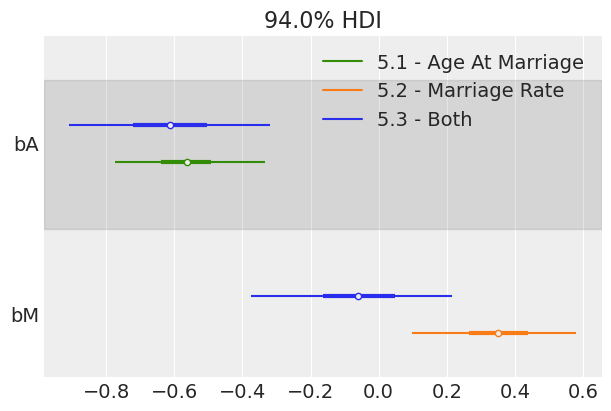

In [389]:
az.plot_forest(
    [
        m_5_3_trace,
        m_5_2_trace,
        m_5_1_trace,
    ],
    model_names=["5.3 - Both", "5.2 - Marriage Rate", "5.1 - Age At Marriage"],
    var_names=["bA", "bM"],
    combined=True,
    figsize=(6,4),
);

How do we interpret this?  Notice that the paramater `bA` does not change between the two models while `bM` drops to near zero when we add in the mean age at marriage.  What this is saying is that most of the association between divorce rate is explained by the mean age at marriage.  Or stated another way as it is in the text marriage rate is not adding predictive power to a model that already includes age at marriage.  Or we can also say that once you have taken into account the age at marriage, divorce rate and marriage rate are not associated.  Or in the notation of DAG's  $D \perp\!\!\!\perp M \vert A$

#### 5.12

In [390]:
N = 50
age = stats.norm().rvs(N)
mar = stats.norm(-age).rvs(N)
div = stats.norm(age).rvs(N)

### 5.1.5.1 Predictor Residual Plot.

This is looking at the error that results when we remove a predictor, and model based on the remaining predictors.  In our case we have two predictors, marriage rate `M` and median age at marriage `A`. For marriage rate this gives the model....

#### 5.13

In [391]:
with pm.Model() as m_5_4:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5) 
    sigma = pm.Exponential("sigma", 1)

    mu = pm.Deterministic("mu", a + bM * data["MedianAgeMarriage_std"].values)

    marriage_std = pm.Normal(
        "Marriage_std", mu=mu, sigma=sigma, observed=data["Marriage_std"].values
    )
    m_5_4_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


#### 5.14

For each state compute the mean of the paramater `mu`.  The residual is the difference between the observed value of `mu` and the value predicted by our model.

In [392]:

mu_m_5_4_mean = m_5_4_trace.posterior["mu"].mean(dim=["chain", "draw"])
residuals = data["Marriage_std"] - mu_m_5_4_mean

Let's plot the residuals as is done in Figure 5.4.

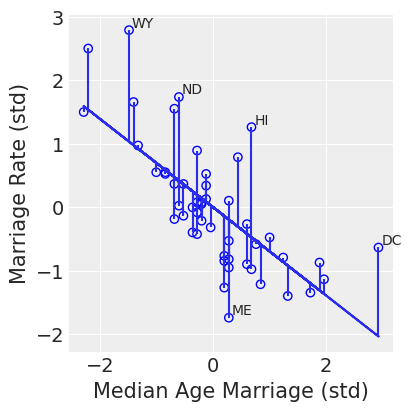

In [393]:
fig, ax = plt.subplots(figsize=(4,4))

age = data["MedianAgeMarriage_std"]
# slope for our mean line.  The intercept is effectivly 0
m = m_5_4_trace.posterior["bM"].values.mean()

# plot our residuals
plt.scatter(age, residuals + (m * age), facecolors="None", edgecolors='blue')

# plot our mean regression line
plt.plot(age, m * age )

# the text labels are for some of the extreme residuals
top5 = residuals.abs().sort_values()[-5:]
for i, txt in zip(top5.index.tolist(), data.loc[top5.index.tolist()]['Loc']):
    ax.annotate(txt, (age[i]+ 0.05, residuals[i] +(m * age[i]) + 0.05))

# plot vertical lines between the regression line and the residual for each state
for i, x in enumerate(age):
    if residuals[i] + (m * age[i]) > m * age[i]:
        ax.vlines(age[i], m * age[i], residuals[i]+ (m * age[i]))
    else:
        ax.vlines(age[i], residuals[i]+ (m * age[i]), m * age[i])

ax.set_xlabel("Median Age Marriage (std)")
ax.set_ylabel("Marriage Rate (std)");

Now lets plot the residuals vs. divorce rate.  First we build the linear model where the data is the residuals.

In [394]:
with pm.Model() as m_5_4_residuals:
    a = pm.Normal("a", 0, 0.2)
    bR = pm.Normal("bR", 0, 0.5) 
    sigma = pm.Exponential("sigma", 1)

    mu = pm.Deterministic("mu", a + bR * residuals)

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    m_5_4_residuals_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bR, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


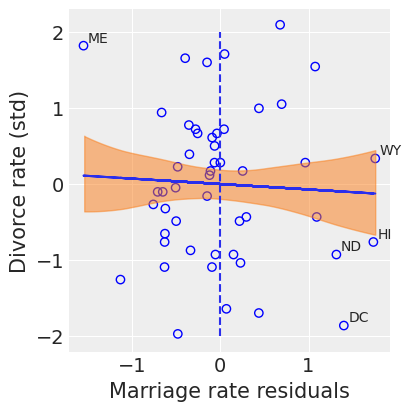

In [395]:
fig, ax = plt.subplots(figsize=(4,4))

# slope for our mean line.  The intercept is effectivly 0
m = m_5_4_residuals_trace.posterior["bR"].values.mean()
dRate = data["Divorce_std"]

# plot our source data
plt.scatter(residuals, dRate, facecolors="None", edgecolors='blue')

# plot our regression line
plt.plot(residuals, m * residuals)

# plot the highest density interval based on our model
mu_pred = m_5_4_residuals_trace.posterior["mu"]
az.plot_hdi(residuals, mu_pred, hdi_prob=0.89)

# the text labels are for some of the extreme residuals
top5 = residuals.abs().sort_values()[-5:]
for i, txt in zip(top5.index.tolist(), data.loc[top5.index.tolist()]['Loc']):
    ax.annotate(txt, (residuals[i] + 0.05, dRate[i] + 0.05))

ax.vlines(0,-2, 2, linestyles="dashed")

ax.set_xlabel("Marriage rate residuals")
ax.set_ylabel("Divorce rate (std)");

Now we do the converse.  We first regress age at marriage `A` on the marriage rate `M`.  Then we will look at the residuals and regress the divorce rate on the age at marriage residuals. 

In [396]:
with pm.Model() as m_5_5:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5) 
    sigma = pm.Exponential("sigma", 1)

    mu = pm.Deterministic("mu", a + bA * data["Marriage_std"].values)

    medianAgemarriage_std = pm.Normal(
        "MedianAgeMarriage_std", mu=mu, sigma=sigma, observed=data["MedianAgeMarriage_std"].values
    )
    m_5_5_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [397]:
mu_m_5_5_mean = m_5_5_trace.posterior["mu"].mean(dim=["chain", "draw"])
residuals_2 = data["MedianAgeMarriage_std"] - mu_m_5_5_mean

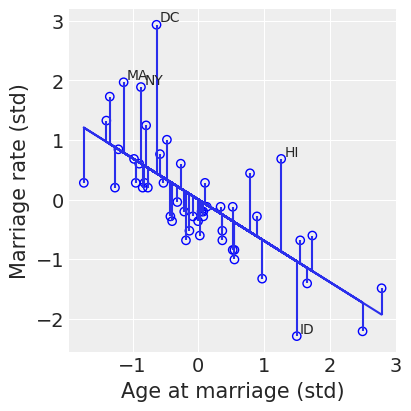

In [398]:
fig, ax = plt.subplots(figsize=(4,4))

mR = data["Marriage_std"]
# slope for our mean line.  The intercept is effectivly 0
m = m_5_5_trace.posterior["bA"].values.mean()

# plot our residuals
plt.scatter(mR, residuals_2 + (m * mR), facecolors="None", edgecolors='blue')

# plot our mean regression line
plt.plot(mR, m * mR )

# the text labels are for some of the extreme residuals
top5 = residuals_2.abs().sort_values()[-5:]
for i, txt in zip(top5.index.tolist(), data.loc[top5.index.tolist()]['Loc']):
    ax.annotate(txt, (mR[i]+ 0.05, residuals_2[i] +(m * mR[i]) + 0.05))

# plot vertical lines between the regression line and the residual for each state
for i, x in enumerate(mR):
    if residuals_2[i] + (m * mR[i]) > m * mR[i]:
        ax.vlines(mR[i], m * mR[i], residuals_2[i]+ (m * mR[i]))
    else:
        ax.vlines(mR[i], residuals_2[i]+ (m * mR[i]), m * mR[i])

ax.set_xlabel("Age at marriage (std)")
ax.set_ylabel("Marriage rate (std)");

In [399]:
with pm.Model() as m_5_5_residuals:
    a = pm.Normal("a", 0, 0.2)
    bRA = pm.Normal("bRA", 0, 0.5) 
    sigma = pm.Exponential("sigma", 1)

    mu = pm.Deterministic("mu", a + bRA * residuals_2)

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    m_5_5_residuals_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bRA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


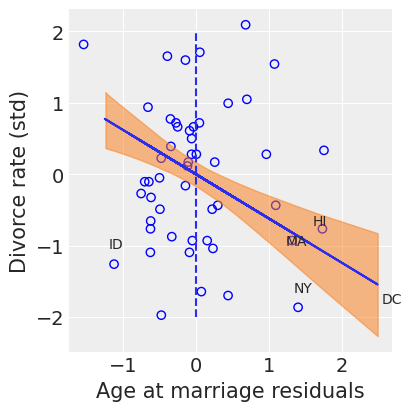

In [400]:
fig, ax = plt.subplots(figsize=(4,4))

# slope for our mean line.  The intercept is effectivly 0
m = m_5_5_residuals_trace.posterior["bRA"].values.mean()
dRate = data["Divorce_std"]

# plot our source data
plt.scatter(residuals, dRate, facecolors="None", edgecolors='blue')

# plot our regression line
plt.plot(residuals_2, m * residuals_2)

# plot the highest density interval based on our model
mu_pred_2 = m_5_5_residuals_trace.posterior["mu"]
az.plot_hdi(residuals_2, mu_pred_2, hdi_prob=0.89)

# the text labels are for some of the extreme residuals
top5 = residuals_2.abs().sort_values()[-5:]
for i, txt in zip(top5.index.tolist(), data.loc[top5.index.tolist()]['Loc']):
    ax.annotate(txt, (residuals_2[i] + 0.05, dRate[i] + 0.05))

ax.vlines(0,-2, 2, linestyles="dashed")

ax.set_xlabel("Age at marriage residuals")
ax.set_ylabel("Divorce rate (std)");

### 5.1.5.2 Posterior prediction plots

#### 5.15

PyMC gives us some handy tools to do prior and posterior checks.  The function [pm.sample_posterior_predictive](https://www.pymc.io/projects/docs/en/latest/api/generated/pymc.sample_posterior_predictive.html) is used to sample paramaters from the posterior distribution.  So to get samples of `mu` and `divorce_rate_std` we do

In [401]:
with m_5_3:
    m_5_3_ppc = pm.sample_posterior_predictive(m_5_3_trace, var_names=["mu", "divorce_rate_std"])

This will give us an arviz.InferenceData object that contains both the observed data and samples of `mu` and `divorce_rate_std` from the posterior distribution.  That is to say the values predicted by the model.

In [402]:
m_5_3_ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

The next step is to get the mean value of `mu` for each state and to compute the highest density intervals around these `mu`'s.

In [403]:
mu_mean = m_5_3_ppc.posterior_predictive["mu"].mean(dim=["chain", "draw"])
mu_PI = az.hdi(m_5_3_ppc.posterior_predictive["mu"], 0.89)

Finaly we can look at the mean value of the `divorce_rate_std` and compute HDI's for each state.

In [404]:
D_sim = m_5_3_ppc.posterior_predictive["divorce_rate_std"].mean(dim=["chain", "draw"])
D_PI = az.hdi(m_5_3_ppc.posterior_predictive["divorce_rate_std"], 0.89)

And now we can plot them

#### 5.16

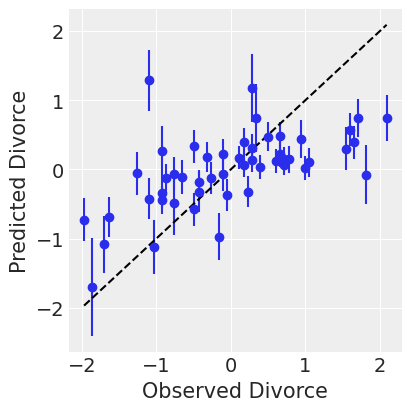

In [405]:
fig, ax = plt.subplots(figsize=(4, 4))
plt.errorbar(
    # the x values are the actual data, standardized divorce rate per state
    data["Divorce_std"].values,
    # the y values are the values predicted by the model
    D_sim,
    # with error bars.  if we give yerr a single value it will draw a symetric bar
    yerr=np.abs(np.array(D_sim) - mu_PI.min(dim="hdi").to_array()),
    fmt="C0o",
)
# find the five states that the model predicts worst on
# errs = np.abs(D_sim - data["Divorce_std"])
# errs_sorted = errs.sortby(errs, ascending=False)[:5]


min_x, max_x = data["Divorce_std"].min(), data["Divorce_std"].max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")

ax.set_ylabel("Predicted Divorce")
ax.set_xlabel("Observed Divorce");

#### 5.17

Overthinking: Simulating spurious association.

Let's generate some simulated data.

#### 5.18

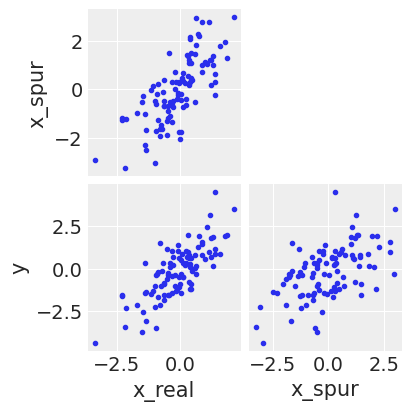

In [506]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)

az.plot_pair({"x_real": x_real, "x_spur": x_spur, "y": y}, figsize=(4,4));

Now we do a linear regression with both `x_real` and `x_spur` as predictors.

In [407]:
with pm.Model() as m_6:
    a = pm.Normal("a", 0, 0.2)
    bR = pm.Normal("bR", 0, 0.5)
    bS = pm.Normal("bS", 0, 0.5) 
    sigma = pm.Exponential("sigma", 1)

    mu = pm.Deterministic("mu", a + bR * x_real + bS * x_spur)

    y = pm.Normal(
        "y", mu=mu, sigma=sigma, observed=y
    )
    m_6_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bR, bS, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


If we look at the paramaters found by our model we see that `bR` dominates since `bS` is close to zero.  That is to say that most of the effect of our modesl comes from the `x_real` data, and not the `x_spur` data since the coeficient of `x_spur`, `bS`,  is close to zero.

In [408]:
m_6_trace.posterior[['bR', 'bS']].mean().values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    bR       float64 1.115
    bS       float64 0.02153>

### 5.1.5.3 Counterfactual plots.

What are the implied predictions of the model?  Another way to think about this is given your model, what if some of the predictor varriables actually had differnt values than those observed, (in fact any other sample we took would indeed be different, but think bigger), In particular let's enforce a range of different values for the varrable and look at how our model responds to those changes.

Specifically, we can specify one out of all the varriables and let it varry while holding the other paramater values fixed.  This lets us test cases that might not actually exist in the big world, so care is needed interpreting the results, but clearly this is of value for exploring our model.

In our example we:
- manipulate the intervention varriable mean age at marriage.
- let it varry by +- 2 std.

The first of these is done like this:

#### 5.19

In [409]:
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

# Use Aesara shared variables
# we will be changing them later when we want
# to run the counterfactual simulations
marriage_shared = shared(data["Marriage_std"].values)
age_shared = shared(data["MedianAgeMarriage_std"].values)

with pm.Model() as m5_3_A:
    # the first part is the same as m_5_3
    # linear modeling the effect of A and D on M
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    # linear model on age and marriage rate
    mu = pm.Deterministic("mu", a + bA * age_shared + bM * marriage_shared)
    # effect on divorce
    divorce = pm.Normal("divorce", mu, sigma, observed=data["Divorce_std"].values)

    # the new part is modeling the effect A has on M.
    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, 0.5)
    aM = pm.Normal("aM", 0, 0.2)
    # linear model on age only
    mu_M = pm.Deterministic("mu_m", aM + bAM * age_shared)
    # effect on marriage
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=data["Marriage_std"].values)

    m5_3_A_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bM, a, sigma_m, bAM, aM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Taking a quick look at the results of fitting the model to confrim that `M` and `A` are negativley correlated.

In [410]:
az.summary(m5_3_A_trace, var_names=['bA', 'bM', 'a', 'bAM', 'aM'], kind="stats")

,mean,sd,hdi_3%,hdi_97%
bA,-0.608,0.158,-0.896,-0.308
bM,-0.061,0.158,-0.354,0.244
a,0.000,0.099,-0.183,0.186
bAM,-0.690,0.099,-0.877,-0.506
aM,-0.002,0.091,-0.170,0.169


Now let's simulate manipulations of A.  We create a range of values for standardized age at marriage.

#### 5.20

In [411]:
# We're setting this to 50 to match the shape of our input
A_seq = np.linspace(-2, 2, 50)
A_seq.shape

(50,)

In [412]:
# With PyMC we have to simulate in each model separately

# Simulate the marriage rates at each age first
# Note: passing an array to age_shared.set_value will result in
# two sets of samples: one for marriage and one for divorce
# at each value in the array.
age_shared.set_value(A_seq)

with m5_3_A:
    m5_3_M_marriage = pm.sample_posterior_predictive(m5_3_A_trace)

In [413]:
m5_3_M_marriage

Inference data with groups:
	> posterior_predictive
	> observed_data

#### 5.22

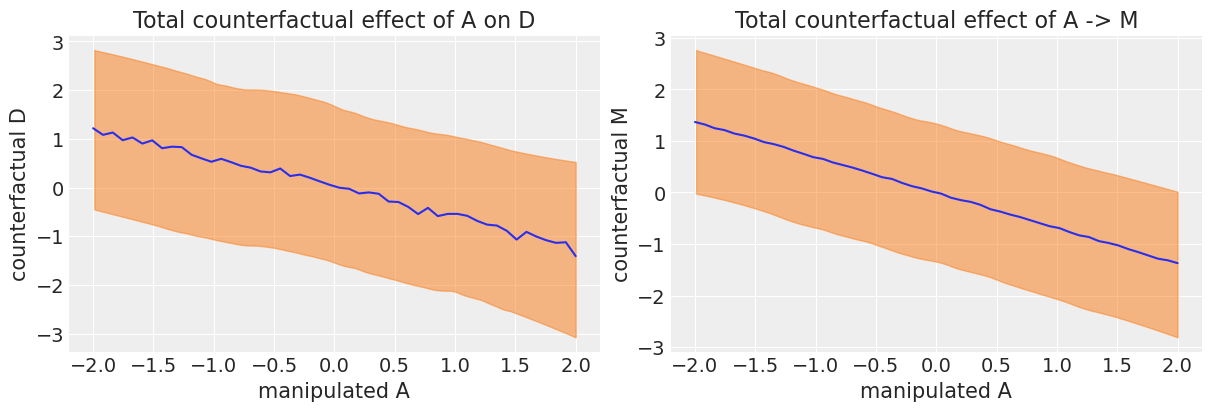

In [414]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
# as A takes values from -2  to 2 standard deviations away from the mean, plot the HDI
az.plot_hdi(A_seq, m5_3_M_marriage.posterior_predictive["divorce"], ax=ax[0])
ax[0].plot(A_seq, m5_3_M_marriage.posterior_predictive["divorce"].mean(dim=["chain", "draw"]))
ax[0].set_title("Total counterfactual effect of A on D")
ax[0].set_xlabel("manipulated A")
ax[0].set_ylabel("counterfactual D")


az.plot_hdi(A_seq, m5_3_M_marriage.posterior_predictive["marriage"], ax=ax[1])
ax[1].plot(A_seq, m5_3_M_marriage.posterior_predictive["marriage"].mean(dim=["chain", "draw"]))
ax[1].set_title("Total counterfactual effect of A -> M")
ax[1].set_xlabel("manipulated A")
ax[1].set_ylabel("counterfactual M");

What if we had full control of M.  Then A would have no influence.

#### 5.23

In [415]:
# We're setting this to 50 to match the shape of our input
#A_seq = (np.linspace(20, 30, 50) - 26.1) / 1.24
A_seq = np.linspace(-2, 2, 50)

age_shared.set_value(A_seq)

with m5_3_A:
    m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)

# Average first and last column and take difference
# (
#     m5_3_M_ppc.posterior_predictive["divorce"][:, -1].mean()
#     - m5_3_M_ppc.posterior_predictive["divorce"][:, 0].mean()
# )

#### 5.23

In [416]:
# Set values for marriage counterfactual
marriage_counter_factual_x = np.linspace(-2, 2, 50)
marriage_shared.set_value(marriage_counter_factual_x)

# Fix age to zero
age_shared.set_value(np.zeros(50))

with m5_3_A:
    m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)

Plotting the effect of M on D we see that it has little effect as we expected.

#### 5.23

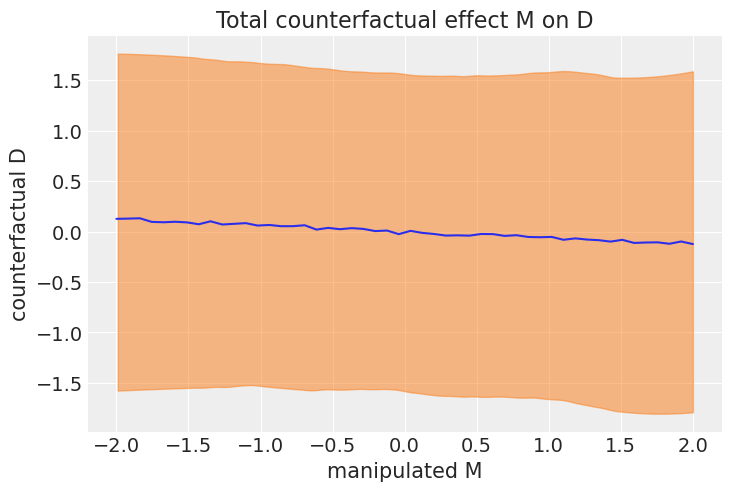

In [417]:
fig, ax = plt.subplots()

az.plot_hdi(marriage_counter_factual_x, m5_3_M_ppc.posterior_predictive["divorce"], ax=ax)
ax.plot(
    marriage_counter_factual_x,
    m5_3_M_ppc.posterior_predictive["divorce"].mean(dim=["chain", "draw"]),
)
ax.set_title("Total counterfactual effect M on D")
ax.set_xlabel("manipulated M")
ax.set_ylabel("counterfactual D");

#### 5.24

In [418]:
A_seq = np.linspace(-2, 2, 30)

#### 5.25

In [419]:
# Get the samples from Age Marriage model first
with m5_3_A:
    # M_sim
    m5_3_M_marriage = pm.sample_posterior_predictive(
        m5_3_A_trace, var_names=["sigma_m", "aM", "bAM"]
    )

#### 5.26

In [420]:
with m5_3_A:
    m5_3_M_divorce = pm.sample_posterior_predictive(
        m5_3_A_trace, var_names=["sigma", "bM", "bA", "a"]
    )

Not sure what these cells are here for.

In [421]:
# create an array where each row is a sample with elements ("aM" + "bAM") * x for x in A_seq 
marriage_mu_counterfactual = np.outer(
    m5_3_M_marriage.posterior_predictive["aM"] + m5_3_M_marriage.posterior_predictive["bAM"], A_seq
)
marriage_mu_counterfactual.shape

(4000, 30)

In [422]:
mu = marriage_mu_counterfactual.T
sigma = az.extract_dataset(m5_3_M_marriage.posterior_predictive["sigma_m"]).to_array()
M_sim = stats.norm(loc=mu, scale=sigma).rvs()
M_sim.shape

(30, 4000)

In [423]:
D_sim = np.zeros((30, 4000))
a = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["a"]).to_array())
bM = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["bM"]).to_array())
bA = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["bA"]).to_array())
sigma = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["sigma"]).to_array())

for i, age_counterfactual in enumerate(A_seq):
    divorce_mu_counterfactual = a + bA * age_counterfactual + bM * M_sim[i, :]
    samples = stats.norm(divorce_mu_counterfactual, sigma).rvs()
    D_sim[i, :] = samples

## 5.2 Masked relationship
#### 5.27

In [424]:
d = pd.read_csv(os.path.join("Data", "milk.csv"), delimiter=";")
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [425]:
d.shape

(29, 8)

#### 5.28

In [426]:
d["K"] = standardize(d["kcal.per.g"])
d["N"] = standardize(d["neocortex.perc"])
d["M"] = standardize(d["mass"])

#### 5.29

In [427]:
# This is meant to fail!  We should have noticed why when we ran cell 5.27 :)
with pm.Model() as m5_5_draft:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * d["N"].values)

    K = pm.Normal("K", mu, sigma, observed=d["K"].values)

    m5_5_draft_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'sigma_log__': array(0.99864774), 'bN': array(-0.08708135), 'a': array(0.91560122)}

Initial evaluation results:
{'sigma': -1.72, 'bN': -0.92, 'a': -1.34, 'K': nan}

Hard to model rusult based on `NaN`s

#### 5.30

In [ ]:
d["neocortex.perc"].head()

0    55.16
1      NaN
2      NaN
3      NaN
4      NaN
Name: neocortex.perc, dtype: float64

In general it is better to figure out other ways to fill in `NaN`s but here we will just drop the rows with `NaN`s for `neocortex.perc`.  That will leave us with 17 data points.

#### 5.31

In [ ]:
dcc = d.dropna(axis=0)
dcc.shape

(17, 11)

#### 5.32

In [ ]:
# so that we can do change this later make shared copy of N
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5_draft:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    # linear on neocortex.pct
    mu = pm.Deterministic("mu", a + bN * shared_N)
    # using the 'cleaned' version of the data
    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_5_draft_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


#### 5.33

In [ ]:
xseq = [-2, 2]
shared_N.set_value(np.array(xseq))
with m5_5_draft:
    m5_5_draft_prior_predictive = pm.sample_prior_predictive()

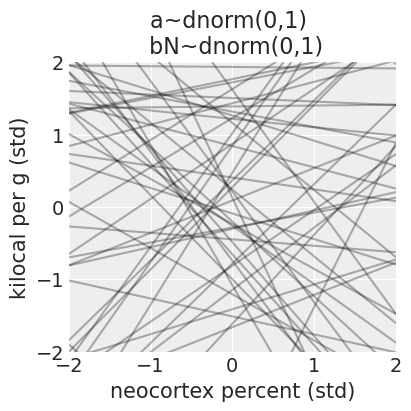

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))

ppr_K = m5_5_draft_prior_predictive.prior_predictive["K"].mean(dim=["chain"])

for i in range(50):
    ax.plot(xseq, ppr_K[i], c="black", alpha=0.3)
ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_title("a~dnorm(0,1) \n bN~dnorm(0,1)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

Lol, those priors.

#### 5.34

In [ ]:
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5:
    sigma = pm.Exponential("sigma", 1)
    # lower the sd for both bN and a
    bN = pm.Normal("bN", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    # linear regression on neocortex.pct
    mu = pm.Deterministic("mu", a + bN * shared_N)
    # using the 'cleaned' version of the data
    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_5_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [ ]:
xseq = [-2, 2]
shared_N.set_value(np.array(xseq))
with m5_5:
    m5_5_prior_predictive = pm.sample_prior_predictive()

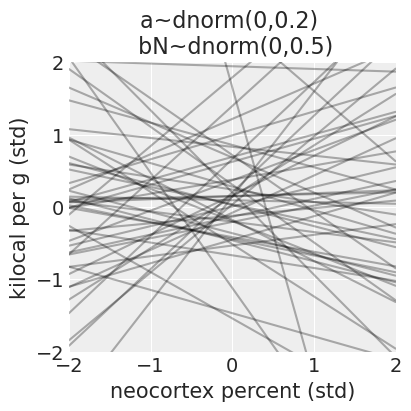

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))

ppr_K = m5_5_prior_predictive.prior_predictive["K"].mean(dim=["chain"])

for i in range(50):
    ax.plot(xseq, ppr_K[i], c="black", alpha=0.3)
ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_title("a~dnorm(0,0.2) \n bN~dnorm(0,0.5)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

OK.  A bit better.  Now, lets look at some summary stats for our model.

#### 5.35

In [ ]:
az.summary(m5_5_trace, var_names=["a", "bN", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.033,0.161,-0.263,0.347,0.003,0.003,3967.0,2421.0,1.0
bN,0.123,0.243,-0.321,0.582,0.004,0.003,4216.0,2758.0,1.0
sigma,1.114,0.207,0.779,1.497,0.003,0.002,4199.0,2795.0,1.0


#### 5.36

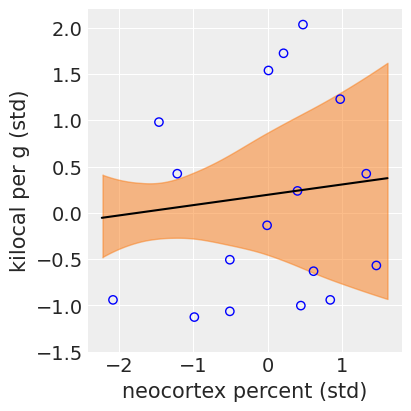

In [490]:
xseq = np.linspace(dcc["N"].min() - 0.15, dcc["N"].max() + 0.15, 17)

shared_N.set_value(xseq)

with m5_5:
    # get samples of mu from the posterior.  By default 4 chains of 1000 draws
    m5_5_posterior_predictive = pm.sample_posterior_predictive(m5_5_trace, var_names=["mu"])
# 
mu_ppd = m5_5_posterior_predictive.posterior_predictive["mu"]
mu_mean = mu_ppd.mean(dim=["chain", "draw"])

fig, ax = plt.subplots(figsize=(4,4))
az.plot_hdi(xseq, mu_ppd, ax=ax)
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["N"], dcc["K"], facecolors="none", edgecolors="b")
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

#### 5.37

In [453]:
# we will want to see what intervention on
# female mass does so make shared varriable.
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_6:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    # linear regression on log female body mass
    mu = pm.Deterministic("mu", a + bM * shared_M)
    # use trimmed data
    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_6_trace = pm.sample()

az.summary(m5_6_trace, var_names=["bM", "a", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,-0.308,0.240,-0.746,0.139,0.004,0.003,3773.0,2596.0,1.0
a,0.048,0.162,-0.251,0.360,0.002,0.002,4760.0,3018.0,1.0
sigma,1.054,0.190,0.743,1.415,0.003,0.002,4974.0,2908.0,1.0


In [439]:
dcc.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,N,M
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-2.080196,-0.515812
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54,-1.063955,-0.508641,-0.382588
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54,-0.506340,-0.508641,-0.377744
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64,1.538249,0.010742,-0.493204
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85,1.724120,0.213470,-0.567082


Let's recreate the rest of Figure 5.9.  You might notice this is different from what is printed in the text.  This code actually produces the correct plot as Confirned from Professor McElreath that this is an erata.

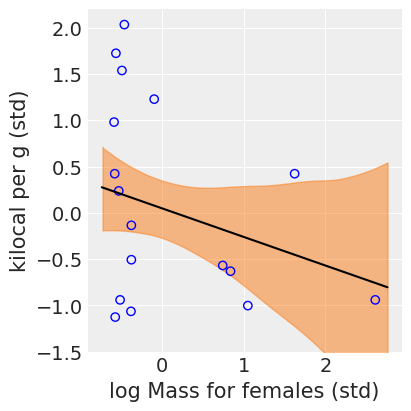

In [454]:
xseq = np.linspace(dcc["M"].min() - 0.15, dcc["M"].max() + 0.15, 17)

shared_M.set_value(xseq)

with m5_6:
    m5_6_posterior_predictive = pm.sample_posterior_predictive(m5_6_trace, var_names=["mu"])

mu_ppd = m5_6_posterior_predictive.posterior_predictive["mu"]
mu_mean = mu_ppd.mean(dim=["chain", "draw"])

fig, ax = plt.subplots(figsize=(4,4))
az.plot_hdi(xseq, mu_ppd, ax=ax)
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["M"], dcc["K"], facecolors="none", edgecolors="b")
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("Mass for females (std)")
ax.set_ylabel("kilocal per g (std)");

#### 5.38

In [468]:
# for analysis later
shared_N = shared(dcc["N"].values)
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_7:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    # linear on both the neocortex.pct and mass.
    mu = pm.Deterministic("mu", a + bN * shared_N + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_7_trace = pm.sample()

az.summary(m5_7_trace, var_names=["a", "bN", "bM", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.063,0.149,-0.235,0.333,0.002,0.002,3623.0,2764.0,1.0
bN,0.382,0.253,-0.084,0.870,0.005,0.004,2545.0,2456.0,1.0
bM,-0.513,0.270,-1.040,-0.025,0.005,0.004,2816.0,2919.0,1.0
sigma,0.972,0.193,0.644,1.335,0.004,0.003,3072.0,2637.0,1.0


#### 5.39

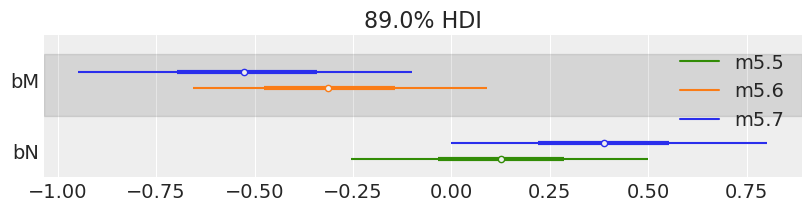

In [478]:
az.plot_forest(
    [m5_7_trace, m5_6_trace, m5_5_trace],
    model_names=["m5.7", "m5.6", "m5.5"],
    var_names=["bM", "bN"],
    combined=True,
    hdi_prob=0.89,
    figsize=(8,2)
);

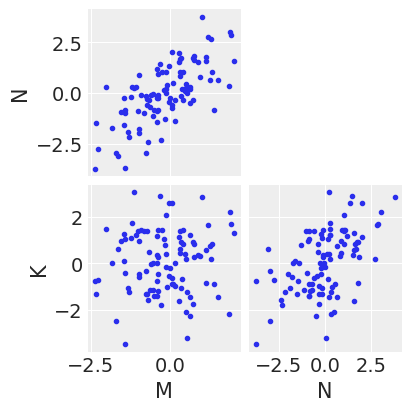

In [487]:
# Professor McElreath suggests viewing the pair plots
az.plot_pair({"M": M, "N": N, "K": K}, figsize=(4,4));

#### 5.40

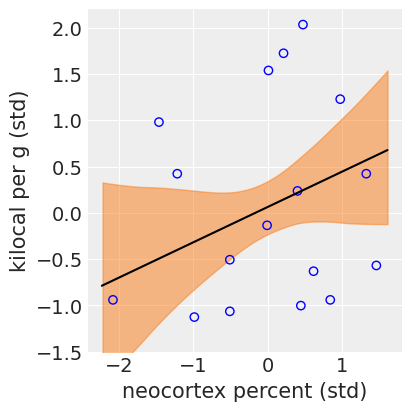

In [503]:
xseq = np.linspace(dcc["N"].min() - 0.15, dcc["N"].max() + 0.15, 17)

shared_N.set_value(xseq)
shared_M.set_value([0]*17)

with m5_7:
    # get samples of mu from the posterior.  By default 4 chains of 1000 draws
    m5_7_posterior_predictive = pm.sample_posterior_predictive(m5_7_trace, var_names=["mu"])
# 
mu_ppd = m5_7_posterior_predictive.posterior_predictive["mu"]
mu_mean = mu_ppd.mean(dim=["chain", "draw"])

fig, ax = plt.subplots(figsize=(4,4))
az.plot_hdi(xseq, mu_ppd, ax=ax)
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["N"], dcc["K"], facecolors="none", edgecolors="b")
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");
ax.set_title("Counterfactual holding M=0")


Text(0.5, 1.0, 'Counterfactual holding N=0')

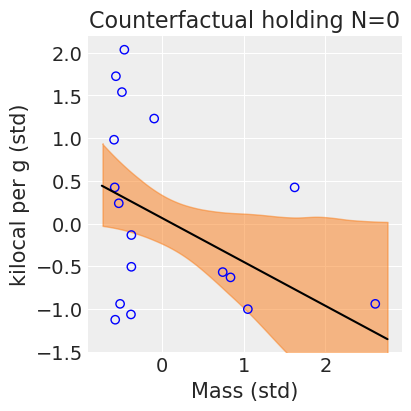

In [505]:
xseq = np.linspace(dcc["M"].min() - 0.15, dcc["M"].max() + 0.15, 17)

# we can use these varriables to see how our model behaves with different conditions
shared_M.set_value(xseq)
shared_N.set_value([0]*17)

with m5_7:
    # get samples of mu from the posterior.  By default 4 chains of 1000 draws
    m5_7_posterior_predictive = pm.sample_posterior_predictive(m5_7_trace, var_names=["mu"])
# 
mu_ppd = m5_7_posterior_predictive.posterior_predictive["mu"]
mu_mean = mu_ppd.mean(dim=["chain", "draw"])

fig, ax = plt.subplots(figsize=(4,4))
az.plot_hdi(xseq, mu_ppd, ax=ax)
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["M"], dcc["K"], facecolors="none", edgecolors="b")
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("Mass (std)")
ax.set_ylabel("kilocal per g (std)")
ax.set_title("Counterfactual holding N=0")

#### 5.41

In [481]:
# Simulate the situation where
# M -> K <- N
# M -> N
# or: K depends on both N and -M
# and  N depends on M
#  
n = 100
M = stats.norm().rvs(n)
N = stats.norm(M).rvs(n)
K = stats.norm(N - M).rvs(n)
d_sim = pd.DataFrame({"K": K, "M": M, "N": N})

#### 5.42

In [ ]:
# M -> K <- N
# N -> M

n = 100
N = stats.norm().rvs(n)
M = stats.norm(N).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim2 = pd.DataFrame({"K": K, "M": M, "N": N})

# M -> K <- N
# M <- U -> N

n = 100
U = stats.norm().rvs(n)
N = stats.norm(U).rvs(n)
M = stats.norm(U).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim3 = pd.DataFrame({"K": K, "M": M, "N": N})

Here is a start at the code for 5.43.  I could not reproduce this in R.
#### 5.43

<Axes: >

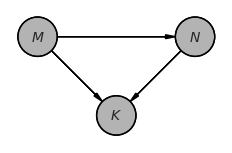

In [510]:
dag_5_7 = BayesianModel([("M", "K"), ("N", "K"), ("M", "N")])
dag_5_7.to_daft(node_pos={"M": (0,1), "N": (2,1), "K": (1,0)}).render()

#### 5.44

In [578]:
d = pd.read_csv(os.path.join("Data", "Howell1.csv"), delimiter=";")
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


Simulating from the priors we see that the $\mu$ for males has a larger standard deviation due to there being more uncertainty because of two paramaters worth of uncertainty, rather than one paramaters worth.
#### 5.45

In [579]:
mu_female = stats.norm(178, 20).rvs(1000)
mu_male = stats.norm(178, 20).rvs(1000) + stats.norm(0, 10).rvs(1000)

az.summary({"mu_female": mu_female, "mu_male": mu_male}, kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu_female,177.884,20.267,137.980,213.598
mu_male,177.114,22.812,136.145,219.808


We do not need to create a new index varriable, since the `male` column in our dataset is already an index varriable ( 0=Female, 1=Male).  For completeness though, here is how you would create a new index varriable with indicies, 1 and 2. 

#### 5.46

In [580]:
d['sex'] = d["male"].apply(lambda x: 2 if x == 1 else 1)

#### 5.47

In [595]:
with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", 0, 50)
    # mu will be a vector with two values since we are including the shape= paramater
    mu = pm.Normal('mu', 178, 20, shape=[2])
    # now in our likelihood function we index on mu using the values of our index values
    # d['male].values
    height = pm.Normal("height", mu[d['male'].values], sigma, observed=d['height'])

    m5_8_trace = pm.sample()

az.summary(m5_8_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],134.875,1.645,131.780,137.934,0.021,0.015,5926.0,3193.0,1.0
mu[1],142.583,1.652,139.621,145.704,0.020,0.014,7075.0,2989.0,1.0
sigma,27.424,0.823,25.945,29.060,0.011,0.008,5740.0,3027.0,1.0


Note that in the above, `mu[0]` is the mean height for females, and `mu[1]` is the mean height for males.

#### 5.48

Rather than simulate from the posterior we can create a model that includes the difference from the female mean height as follows.

In [597]:
with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Normal("mu", 178, 20, shape=[2])
    height = pm.Normal("height", mu[d['male'].values], sigma, observed=d["height"])

    # With PyMC it's easier just to create a deterministic that includes both values
    diff_fm = pm.Deterministic("diff", mu[0] - mu[1])

    m5_8_trace = pm.sample()

az.summary(m5_8_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],134.883,1.634,131.698,137.729,0.023,0.016,4975.0,2599.0,1.0
mu[1],142.580,1.693,139.556,145.939,0.022,0.015,5991.0,3119.0,1.0
sigma,27.409,0.827,25.793,28.870,0.011,0.008,5729.0,3041.0,1.0
diff,-7.697,2.346,-11.996,-3.239,0.033,0.024,4926.0,3107.0,1.0


#### 5.49

In [598]:
d = pd.read_csv(os.path.join("Data", "milk.csv"), delimiter=";")
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


The pandas function [`pd.Categorical()`](https://pandas.pydata.org/docs/reference/api/pandas.Categorical.html) helps us with creating our categories.  To add a numerical index column we do this.

#### 5.50

In [599]:
d["clade_id"] = pd.Categorical(d["clade"]).codes

#### 5.51

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


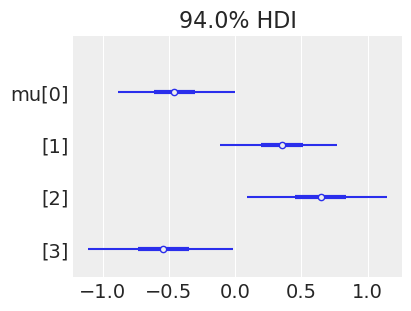

In [602]:
d["K"] = standardize(d["kcal.per.g"])

with pm.Model() as m5_9:
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Normal("mu", 0, 0.5, shape=[d["clade_id"].max() + 1])
    K = pm.Normal("K", mu[d["clade_id"].values], sigma, observed=d["K"])

    m5_9_trace = pm.sample()

az.plot_forest(m5_9_trace, combined=True, var_names=["mu"], figsize=(4,3));

#### 5.52

In [603]:
d["house"] = np.random.randint(0, 4, size=d.shape[0])

#### 5.54

In [604]:
with pm.Model() as m5_10:
    sigma = pm.Exponential("sigma", 1)
    mu_house = pm.Normal("mu_house", 0, 0.5, shape=[d["house"].max() + 1])
    mu_clade = pm.Normal("mu_clade", 0, 0.5, shape=[d["clade_id"].max() + 1])
    mu = mu_clade[d["clade_id"].values] + mu_house[d["house"].values]

    K = pm.Normal("K", mu, sigma, observed=d["K"])

    m5_9_trace = pm.sample()

az.summary(m5_9_trace, var_names=["mu_clade", "mu_house"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_house, mu_clade]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_clade[0],-0.417,0.270,-0.946,0.065,0.005,0.003,3367.0,3221.0,1.0
mu_clade[1],0.286,0.275,-0.209,0.821,0.005,0.004,3331.0,3154.0,1.0
mu_clade[2],0.580,0.307,0.048,1.198,0.005,0.003,4188.0,3400.0,1.0
mu_clade[3],-0.446,0.324,-1.028,0.191,0.005,0.004,4413.0,3362.0,1.0
mu_house[0],0.055,0.316,-0.543,0.640,0.005,0.004,3668.0,3242.0,1.0
mu_house[1],-0.345,0.297,-0.918,0.202,0.005,0.003,3997.0,3263.0,1.0
mu_house[2],0.382,0.284,-0.135,0.936,0.005,0.004,3232.0,3256.0,1.0
mu_house[3],-0.103,0.274,-0.619,0.395,0.005,0.004,3692.0,3487.0,1.0


In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Jul 09 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

arviz     : 0.12.1
numpy     : 1.22.1
pymc      : 4.0.0
pandas    : 1.4.2
matplotlib: 3.5.2
scipy     : 1.7.3
daft      : 0.1.2

Watermark: 2.3.1

